In [1]:
%pwd

'/home/radovan/Dropbox/private/udacity/CarND-Behavioral-Cloning-P3'

In [49]:
import csv
import cv2
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Cropping2D, Dropout, Conv2D
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D


def load_data(img_path):
    lines_df = pd.read_csv(img_path + 'driving_log.csv')
    lines_df.columns=['center_img','left_img','right_img','steer_angle', 'throttle', 'brake', 'speed']

    X = lines_df[[ 'center_img', 'left_img', 'right_img']].values
    y = lines_df['steer_angle'].values

    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, shuffle=True, random_state=15)

    return X_train, X_valid, y_train, y_valid



def batch_generator(X_paths,y_val,batch_size):
    assert batch_size%6==0, "batch_size must be divisable by six"
    correction = 0.2
    num_lines=len(X_paths)
    images       = np.empty((batch_size,160,320,3))
    measurements = np.empty(batch_size)
    while 1:
        i = 0
        for ix in np.random.permutation(X_paths.shape[0]):
        #for ix in range(X_paths.shape[0]):
          #center camera-----------------------------------------
            center_path = X_paths[ix][0]
            image = cv2.imread(center_path)
            images[i]=image
            center_steering = np.copy(y_val[ix])
            measurements[i]=center_steering
            i=i+1

          #center camera flipped
            images[i]=cv2.flip(image,1)
            measurements[i]=center_steering*-1
            #measurements[i]=5
            i=i+1

          #left camera--------------------------------------------
            left_path  = X_paths[ix][1]
            image = cv2.imread(left_path)
            images[i]=image
            left_steering = center_steering+correction
            measurements[i]=left_steering
            i=i+1

          #left camera flipped
            images[i]=cv2.flip(image,1)
            measurements[i]=left_steering*-1
            i=i+1

          #right camera--------------------------------------------
            right_path = X_paths[ix][2]
            image = cv2.imread(right_path)
            images[i]=image
            right_steering = center_steering-correction
            measurements[i]=right_steering
            i=i+1

          #right camera flipped
            images[i]=cv2.flip(image,1)
            measurements[i]=right_steering*-1
            
            i=i+1
            if i==batch_size:
                i=0
                yield np.array(images), np.array(measurements)
        #yield (images,measurements)
        #yield np.array(images), np.array(measurements)
        #i = 0

def LeNet_Model():
    model =Sequential()
    model.add(Lambda(lambda x: x/255.0 -0.5, input_shape=(160,320,3)))
    model.add(Cropping2D(cropping=((70,25), (0,0))))
    model.add(Convolution2D(6,kernel_size=(5, 5),activation='relu'))
    model.add(MaxPooling2D())
    model.add(Convolution2D(16,kernel_size=(5, 5),activation='relu'))
    model.add(MaxPooling2D())
    model.add(Convolution2D(16,kernel_size=(5, 5),activation='relu'))
    model.add(MaxPooling2D())
    model.add(Flatten())
    model.add(Dropout(0.2))
    model.add(Dense(120))
    model.add(Dropout(0.2))
    model.add(Dense(84))
    model.add(Dense(1))
    return model

def NVIDIA_Model():
    model =Sequential()
    model.add(Lambda(lambda x: x/255.0 -0.5, input_shape=(160,320,3)))
    model.add(Cropping2D(cropping=((70,25), (0,0))))
    
    model.add(Conv2D(24,kernel_size=(5, 5),strides=(2,2),activation='relu'))
    model.add(Conv2D(36,kernel_size=(5, 5),strides=(2,2),activation='relu'))
    model.add(Conv2D(48,kernel_size=(5, 5),strides=(2,2),activation='relu'))
    model.add(Conv2D(64,kernel_size=(3, 3),activation='relu'))
    model.add(Conv2D(64,kernel_size=(3, 3),activation='relu'))
    
    model.add(Flatten())
    #model.add(Dropout(0.2))
    model.add(Dense(100))
    #model.add(Dropout(0.2))
    model.add(Dense(50))
    model.add(Dense(10))
    model.add(Dense(1))
    return model

model=NVIDIA_Model()
#model=LeNet_Model()
model.compile(loss='mse',optimizer='adam')
img_path='/media/radovan/Samsung_T3/logs/udacity/'
X_train, X_valid, y_train, y_valid=load_data(img_path)
print('There is ',X_train.shape[0],' training images')
batch_size=120
train_gen = batch_generator(X_train,y_train,batch_size)
valid_gen = batch_generator(X_valid,y_valid,batch_size)

history_object = model.fit_generator(train_gen,
                                     steps_per_epoch=len(X_train)/batch_size,
                                     epochs=5, 
                                     verbose=1, 
                                     validation_data=valid_gen, 
                                     validation_steps=len(X_valid)/batch_size,
                                     shuffle=True)
model.save('model.h5')

There is  7786  training images
Epoch 1/5
65/64 [==============================] - 19s 294ms/step - loss: 0.0366 - val_loss: 0.0351
Epoch 2/5
65/64 [==============================] - 17s 261ms/step - loss: 0.0273 - val_loss: 0.0236
Epoch 3/5
65/64 [==============================] - 17s 265ms/step - loss: 0.0278 - val_loss: 0.0296
Epoch 4/5
65/64 [==============================] - 18s 276ms/step - loss: 0.0260 - val_loss: 0.0225
Epoch 5/5
65/64 [==============================] - 17s 267ms/step - loss: 0.0282 - val_loss: 0.0261


dict_keys(['val_loss', 'loss'])


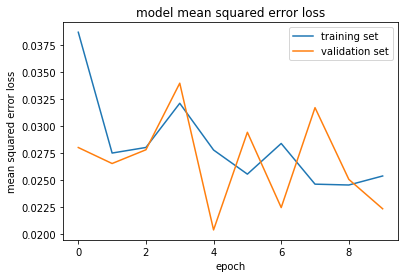

In [48]:
### print the keys contained in the history object
print(history_object.history.keys())

### plot the training and validation loss for each epoch

plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
#plt.show()
plt.savefig('learning.png')


In [2]:
from keras.utils import plot_model
plot_model(model, to_file='model.png')

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
X_train.shape[0]

7786

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


y[0] 0.03755869
y[1] -0.03755869
y[2] 0.23755869000000002
y[3] -0.23755869000000002
y[4] -0.16244131
y[5] 0.16244131


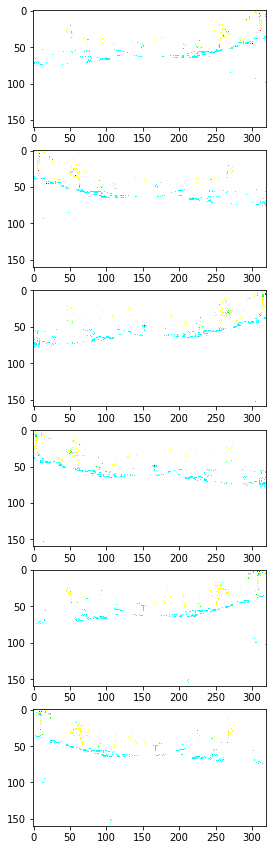

In [7]:
a=next(train_gen)

X,y=a

sample_ix=12
print('y[0]',y[sample_ix+0])
print('y[1]',y[sample_ix+1])
print('y[2]',y[sample_ix+2])
print('y[3]',y[sample_ix+3])
print('y[4]',y[sample_ix+4])
print('y[5]',y[sample_ix+5])
f, (ax0,ax1,ax2,ax3,ax4,ax5) =plt.subplots(6,figsize=(20,15))
ax0.imshow(X[sample_ix+0])
ax1.imshow(X[sample_ix+1])
ax2.imshow(X[sample_ix+2])
ax3.imshow(X[sample_ix+3])
ax4.imshow(X[sample_ix+4])
ax5.imshow(X[sample_ix+5])

In [50]:
#x1,y1=next(train_gen)
x1_v,y1_v=next(valid_gen)


In [8]:

x1_v[999]

array([[[ 228.,  176.,  140.],
        [ 228.,  176.,  140.],
        [ 227.,  175.,  139.],
        ..., 
        [ 178.,  139.,  111.],
        [ 179.,  140.,  112.],
        [ 179.,  140.,  112.]],

       [[ 228.,  176.,  140.],
        [ 228.,  176.,  140.],
        [ 228.,  176.,  140.],
        ..., 
        [ 179.,  140.,  112.],
        [ 179.,  140.,  112.],
        [ 179.,  140.,  112.]],

       [[ 229.,  177.,  141.],
        [ 229.,  177.,  141.],
        [ 229.,  177.,  141.],
        ..., 
        [ 180.,  141.,  113.],
        [ 180.,  141.,  113.],
        [ 180.,  141.,  113.]],

       ..., 
       [[ 155.,  173.,  172.],
        [  66.,   84.,   83.],
        [ 107.,  125.,  124.],
        ..., 
        [  89.,   96.,   91.],
        [  85.,   92.,   87.],
        [  97.,  104.,   99.]],

       [[ 145.,  163.,  162.],
        [ 157.,  175.,  174.],
        [ 131.,  149.,  148.],
        ..., 
        [ 107.,  114.,  109.],
        [ 105.,  112.,  107.],
        [ 

In [52]:
aa=[1,2,3,4,5,7,8,3,4,5,6,6,7,88,9,0,0]
def some_gen(array):
    ret=np.empty(2)
    while True:
        i=0
        for ix in range(len(array)):
            ret[i]=array[ix]
            i=i+1
            if i==2:
                print('ix:',ix)
                i=0
                yield ret
        
aa_gen=some_gen(aa)
a1=next(aa_gen)
a1

ix: 1


array([ 1.,  2.])

In [55]:
a1=next(aa_gen)
a1

ix: 7


array([ 8.,  3.])

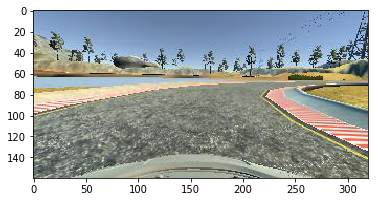

In [27]:
image = cv2.imread(X_train[170][0])
image2 = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
f, ax = plt.subplots(1)
ax.imshow(image2)
f.savefig("center")

In [31]:
img_center        = cv2.imread(X_train[170][0])
img_center        = cv2.cvtColor(img_center, cv2.COLOR_BGR2RGB)
img_center_fliped =cv2.flip(img_center,1)

img_left        = cv2.imread(X_train[170][1])
img_left        = cv2.cvtColor(img_left, cv2.COLOR_BGR2RGB)
img_left_fliped =cv2.flip(img_left,1)

img_right        = cv2.imread(X_train[170][2])
img_right        = cv2.cvtColor(img_right, cv2.COLOR_BGR2RGB)
img_right_fliped =cv2.flip(img_right,1)

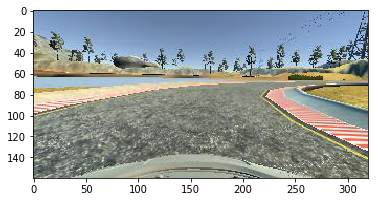

In [32]:
f, ax = plt.subplots(1)
ax.imshow(img_center)
f.savefig("center")

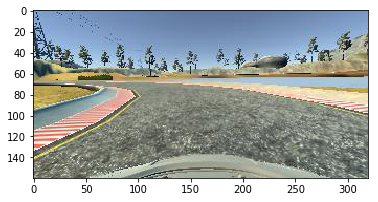

In [33]:
f, ax = plt.subplots(1)
ax.imshow(img_center_fliped)
f.savefig("center_fliped")

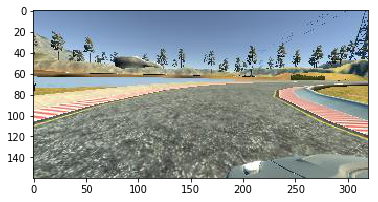

In [34]:
f, ax = plt.subplots(1)
ax.imshow(img_left)
f.savefig("left")

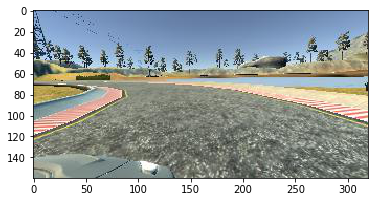

In [35]:
f, ax = plt.subplots(1)
ax.imshow(img_left_fliped)
f.savefig("left_fliped")

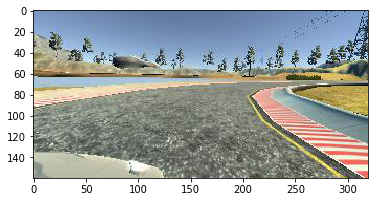

In [36]:
f, ax = plt.subplots(1)
ax.imshow(img_right)
f.savefig("right")

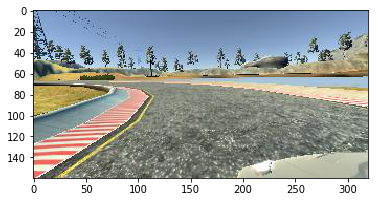

In [37]:
f, ax = plt.subplots(1)
ax.imshow(img_right_fliped)
f.savefig("right_fliped")

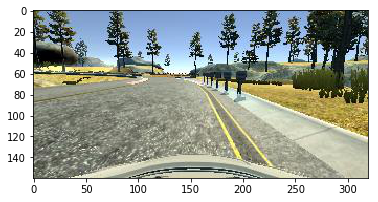

In [39]:
recovery_path='/media/radovan/Samsung_T3/logs/udacity/IMG/center_2018_12_01_23_29_48_719.jpg'
img_recovery        = cv2.imread(recovery_path)
img_recovery        = cv2.cvtColor(img_recovery, cv2.COLOR_BGR2RGB)
f, ax = plt.subplots(1)
ax.imshow(img_recovery)
f.savefig("recovery")